# Implementing a simple perceptron in python

In [1]:
import pylab as pl
import numpy as np
import matplotlib.cm as cm
import sklearn.cross_validation as skcross
%pylab inline --no-import-all

np.set_printoptions(precision=5, suppress=True)

def dataset_fixed_cov():
    n, dim = 300, 2
    np.random.seed(42)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n))).astype(np.int)
    return X, y

X, y = dataset_fixed_cov()

print X

Populating the interactive namespace from numpy and matplotlib
[[-0.11476 -0.14605]
 [ 1.26411  0.20133]
 [-0.19433  0.     ]
 ..., 
 [ 1.36559  1.4677 ]
 [ 1.45857  1.13159]
 [ 2.13224  1.26225]]


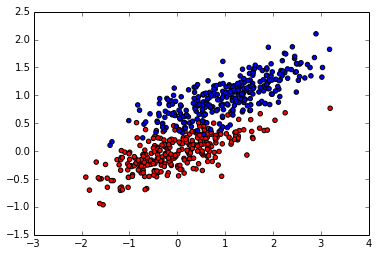

In [2]:
pl.scatter(X[y==0, 0], X[y==0, 1], c='r')
pl.scatter(X[y==1, 0], X[y==1, 1], c='b')

## Perceptron implementation

We build a perceptron with a sigmoid activation function. That is

$$o_i = sigmoid(W*x_i + b)$$

Where $sigmoid(x) = \frac{1}{1 + e^{-x}}$

The error is simply ($y_i$ being the expected output value)

$$e_i = (y_i - o_i)^2$$

With an optional weight decay term :

$$e_i = (y_i - o_i)^2 + \frac{\alpha}{2}W^TW$$

We train the network with minibatch SGD. That is, at each epoch, we compute the average gradient over a bunch of examples as opposed to a single one.

### Error function derivative

Note that if we add an entry set to 1 at the end of the x vector, we can transform our $Wx + b$ into $W\hat{x} + b$ where $\hat{x} = \left[\begin{matrix}x \\ 1 \end{matrix}\right]$

$$l_i = W\hat{x}$$

$$o_i = sigmoid(l_i)$$

$$e_i = (y_i - o_i)^2$$

We want to compute the derivative of $e_i$ w.r.t $W$. From the [chain rule](http://en.wikipedia.org/wiki/Chain_rule), we have


$$\frac{\partial e_i}{\partial W} = \frac{\partial e_i}{\partial o_i} \frac{\partial o_i}{\partial l_i} \frac{\partial l_i}{\partial W}$$

With
$$\frac{\partial e_i}{\partial o_i} = -2(y_i - o_i)$$
$$\frac{\partial o_i}{\partial l_i} = sigmoid(l_i)(1 - sigmoid(l_i)$$
$$\frac{\partial l_i}{\partial W} = \hat{x}$$

Which gives us

$$\frac{\partial e_i}{\partial W} = -2(y_i - o_i) sigmoid(l_i)(1 - sigmoid(l_i) \hat{x}$$

Which we use to update our weights at each step of gradient descent :

$$W^{t+1} = W^t - \frac{\partial e_i}{\partial W}$$

![avatar](https://obohe.com/i/2021/12/12/extc46.png)

In [3]:
# activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class Perceptron(object):
    def __init__(self, X_dim, activation='sigmoid'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_deriv = sigmoid_derivative
        else:
            raise ValueError('Unknown activation function %s' % activation)
            
        nweights = X_dim + 1
        self.W = (2 * np.random.random(nweights)) * 0.25
        self.W = self.W.reshape(-1, 1)
        self.train_errors = []
        self.validation_errors = []
    
    def _add_bias_X(self, X):
        """Returns X with an additional entry set to 1, representing bias"""
        temp = np.ones([X.shape[0], X.shape[1]+1])
        temp[:, :-1] = X
        return temp
    
    def _error_derivative(self, y_true, y_pred, y_pred_prime):
        return -2 * (y_true - y_pred) * y_pred_prime
    
    def _error(self, y_true, y_pred):
        return (y_true - y_pred)**2
        
    def train(self, X_train, y_train, X_validation, y_validataion,
              learning_rate=0.2, epochs=10, minibatch_size=10, weight_decay=0):
        assert len(X_train.shape) == 2, "X must be 2D"
        X_train = self._add_bias_X(X_train)
        X_validation = self._add_bias_X(X_validation)
        
        self.weight_decay = weight_decay
        
        # minibatch SGD 
        for epoch in range(epochs):
            minibatch_indices = np.arange(X_train.shape[0])
            np.random.shuffle(minibatch_indices)
            # for each minibatch, compute gradient of weights
            for start in xrange(0, len(minibatch_indices), minibatch_size):
                end = start + minibatch_size
                indices = minibatch_indices[start:end]
                Xb = X_train[indices]
                yb = y_train[indices]
                
                l = Xb.dot(self.W).flatten()
                deltas = self._error_derivative(yb, self.activation(l), self.activation_deriv(l))
                grad_W = Xb * np.tile(deltas.reshape(-1, 1), (1, Xb.shape[1]))
                grad_W = np.mean(grad_W, axis=0).reshape(-1, 1)
                self.W -= learning_rate * grad_W + self.weight_decay * self.W
            
            # evaluate train/validation errors
            self.train_errors.append(
                self._error(y_train, self.decision_function(X_train, addbias=False)).mean()
            )
            self.validation_errors.append(
                self._error(y_validation, self.decision_function(X_validation, addbias=False)).mean()
            )
        
        return self
                    
                    
    def predict(self, X, addbias=True):
        return (self.decision_function(X, addbias) > 0.5).astype(np.int)


    def decision_function(self, X, addbias=True):
        """
        - if addbias is True, an entry with 1 will be added to X to represent the bias.
        """
        if addbias:
            X = self._add_bias_X(X)
        return self.activation(X.dot(self.W).flatten())

In [4]:
X_train, X_validation, y_train, y_validation = skcross.train_test_split(X, y, test_size=0.33)
perceptron = Perceptron(X.shape[1]).train(X_train, y_train, X_validation, y_validation,
                                          epochs=50, minibatch_size=10)

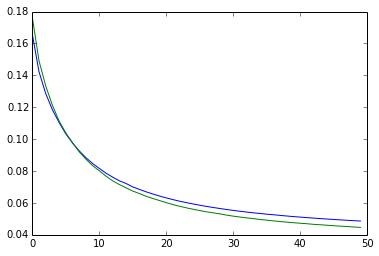

In [5]:
pl.plot(perceptron.train_errors, label='train')
pl.plot(perceptron.validation_errors, label='validation')

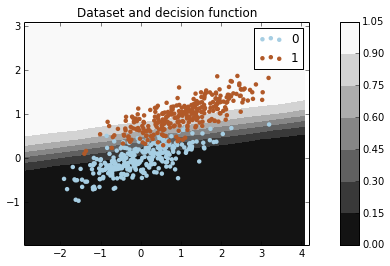

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def show_decision_boundary(clf, X, y, subplot_spec=None):
    assert X.shape[1] == 2
    wratio = (15, 1)
    if subplot_spec is None:
        gs = gridspec.GridSpec(1,2, width_ratios=wratio)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=subplot_spec, width_ratios=wratio)
        
    ax = pl.subplot(gs[0])
    ax.set_title('Dataset and decision function')
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.2 # step size in the meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ctr = ax.contourf(xx, yy, Z, cmap=cm.gray, vmin=0, vmax=1)
    
    unique_labels = np.unique(y)
    colors = cm.Paired(np.linspace(0, 1, num=len(unique_labels)))
    for i, yi in enumerate(unique_labels):
        color = colors[i]
        ax.scatter(X[y == yi, 0], X[y == yi, 1], c=color, linewidth=0, label='%d' % yi)
    ax.legend()
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

    pl.colorbar(ctr, cax=pl.subplot(gs[1]))

show_decision_boundary(perceptron, X, y)